In [1]:
from helpers import create_csv_submission
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from common import sigmoid
from mie import build_k_indices, cross_validation, subsample_class
from performance import accuracy, f1_score

Load data

In [8]:
x_train_norm = np.load("processed/x_train.npy")
x_test_norm = np.load("processed/x_test.npy")
y_train = np.load("processed/y_train.npy")
test_ids = np.load("processed/test_ids.npy")
train_ids = np.load("processed/train_ids.npy")

y_train = (y_train + 1) / 2  # from -1/1 to 0/1
np.unique(y_train)

# Add bias term to X (column of 1)
x_train_norm = np.hstack([np.ones((x_train_norm.shape[0], 1)), x_train_norm])
x_test_norm = np.hstack([np.ones((x_test_norm.shape[0], 1)), x_test_norm])

Cross validation

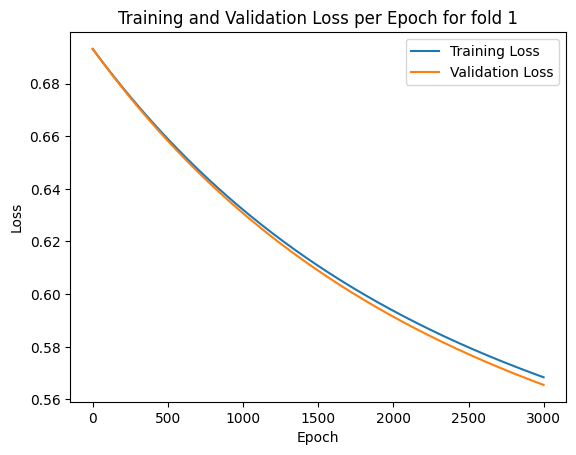

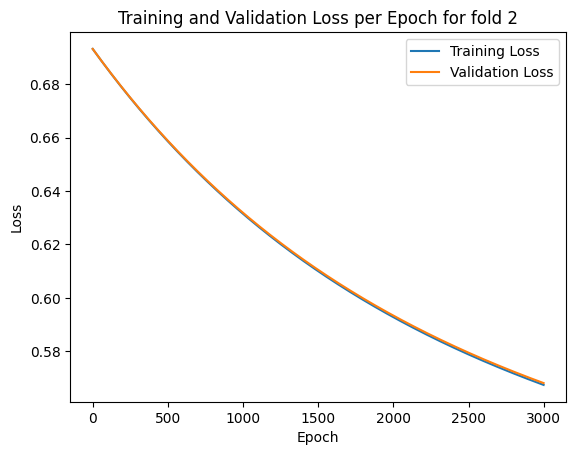

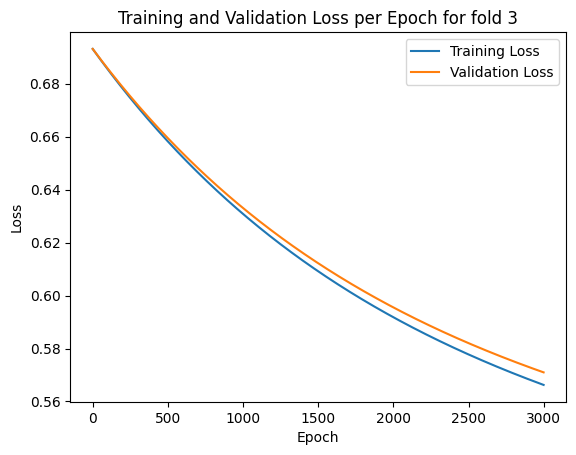

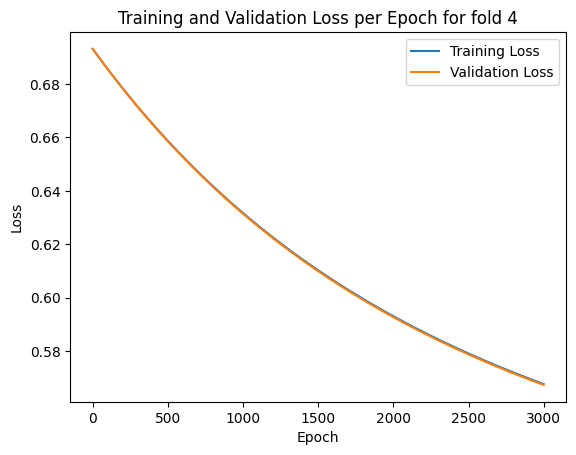

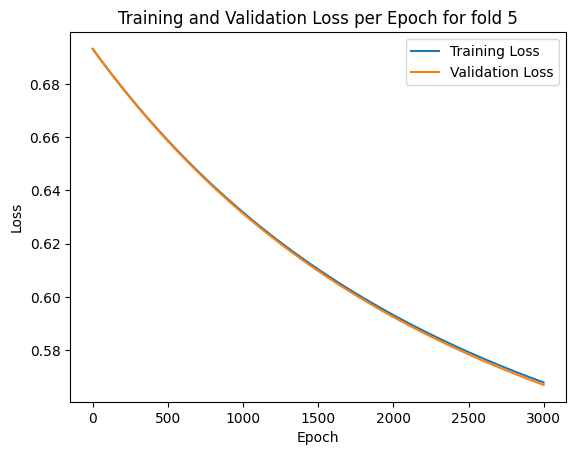

Mean accuracy:  0.5276445211389129
Mean F1:  0.6907927725811331


In [ ]:
x_train_norm, y_train = subsample_class(x_train_norm, y_train, target_ratio=1.0)


k_fold=5
k_indices=build_k_indices(y_train, k_fold, seed=42)

loss_val=[]
loss_tr=[]
ws=[]
acc_scores=[]
f1_scores=[]
initial_w = np.zeros((x_train_norm.shape[1], 1))

for k in range(k_fold):
    w, loss_tr_tmp, loss_val_tmp, x_val, y_val = cross_validation(y_train, x_train_norm, k_indices, k, initial_w, max_iters=3000, gamma= 0.2 / x_train_norm.shape[1])
    loss_tr.append(loss_tr_tmp[-1])
    loss_val.append(loss_val_tmp[-1])
    ws.append(w)

    plt.plot(loss_tr_tmp, label='Training Loss')
    plt.plot(loss_val_tmp, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss per Epoch for fold {k+1}')
    plt.legend()
    plt.show()

    y_pred_prob = sigmoid(x_val @ w)
    y_pred = np.where(y_pred_prob >= 0.5, 1, -1)
    acc = accuracy(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    acc_scores.append(acc)
    f1_scores.append(f1)
   
w_best=np.mean(ws, axis=0)

print("Mean accuracy: ", np.mean(acc_scores))
print("Mean F1: ", np.mean(f1_scores))

Test

In [10]:
y_pred_prob = sigmoid(x_test_norm @ w_best)
y_pred = np.where(y_pred_prob >= 0.5, 1, -1)

create_csv_submission(test_ids, y_pred, 'Train2')